In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torch torchvision -q

In [ ]:
import h5py
import numpy as np
import cv2
import torch

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [ ]:
# Carregar o arquivo HDF5
file_path = '/content/drive/MyDrive/train_images.h5'
with h5py.File(file_path, 'r') as f:
    dataset_name = list(f.keys())[0]
    images = np.array(f[dataset_name])

# Redimensionar e converter as imagens para escala de cinza
images_resized = []
for img in images:
    resized_img = cv2.resize(img, (64, 64))  # Redimensionar para 64x64
    if resized_img.ndim == 3:  # Se a imagem tiver 3 canais
        resized_img = cv2.cvtColor(resized_img, cv2.COLOR_RGB2GRAY)  # Converter para escala de cinza
    images_resized.append(resized_img)

# Converter as imagens para tensor e adicionar dimensão de canal
images_tensor = torch.tensor(np.array(images_resized), dtype=torch.float32).unsqueeze(1)

# Criar um DataLoader
batch_size = 64
dataset = TensorDataset(images_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1 * 64 * 64),  # Ajuste para gerar imagens de 64x64
            nn.Tanh()  # Usar Tanh para normalizar a saída entre -1 e 1
        )

    def forward(self, z):
        return self.model(z).view(-1, 1, 64, 64)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.flattened_size = 32 * 16 * 16
        self.fc = nn.Linear(self.flattened_size, 1)

    def forward(self, x):
        x = self.leaky_relu(self.conv1(x))
        x = self.leaky_relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        return torch.sigmoid(self.fc(x))

In [ ]:
# Hiperparâmetros
num_epochs = 100  # Número de épocas para treinamento
learning_rate = 0.0001  # Taxa de aprendizado reduzida
latent_dim = 100  # Dimensão do espaço latente

# Inicializar os modelos
generator = Generator()
discriminator = Discriminator()

# Definir otimizadores
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate)
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate)

# Definir a função de perda
criterion = nn.BCELoss()

In [ ]:
for epoch in range(num_epochs):
    for i, (real_images,) in enumerate(dataloader):
        # Criar rótulos reais e falsos
        real_labels = torch.ones(real_images.size(0), 1)  # Rótulos reais
        fake_labels = torch.zeros(real_images.size(0), 1)  # Rótulos falsos

        # Treinar o Discriminador várias vezes
        for _ in range(5):  # Atualiza o discriminador 5 vezes
            optimizer_D.zero_grad()
            outputs = discriminator(real_images)
            d_loss_real = criterion(outputs, real_labels)

            z = torch.randn(real_images.size(0), latent_dim)
            fake_images = generator(z)
            outputs = discriminator(fake_images.detach())  # Não calcular gradiente para o gerador
            d_loss_fake = criterion(outputs, fake_labels)

            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            torch.nn.utils.clip_grad_norm_(discriminator.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer_D.step()

        # Treinar o Gerador uma vez
        optimizer_G.zero_grad()
        outputs = discriminator(fake_images)
        g_loss = criterion(outputs, real_labels)
        g_loss.backward()
        torch.nn.utils.clip_grad_norm_(generator.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer_G.step()

    # Exibir as perdas a cada 10 épocas
    if (epoch + 1) % 10 == 0:
        print(f'Época [{epoch + 1}/{num_epochs}], Perda D: {d_loss.item():.4f}, Perda G: {g_loss.item():.4f}')

Época [10/100], Perda D: 0.0001, Perda G: 10.1426
Época [20/100], Perda D: 0.0000, Perda G: 17.2587
Época [30/100], Perda D: 0.0000, Perda G: 12.7242
Época [40/100], Perda D: 0.0000, Perda G: 22.2605
Época [50/100], Perda D: 0.0000, Perda G: 27.2987
Época [60/100], Perda D: 0.0000, Perda G: 12.6350
Época [70/100], Perda D: 0.0000, Perda G: 19.4843
Época [80/100], Perda D: 0.0000, Perda G: 24.0409
Época [90/100], Perda D: 0.0000, Perda G: 10.2889
Época [100/100], Perda D: 0.0000, Perda G: 15.2834


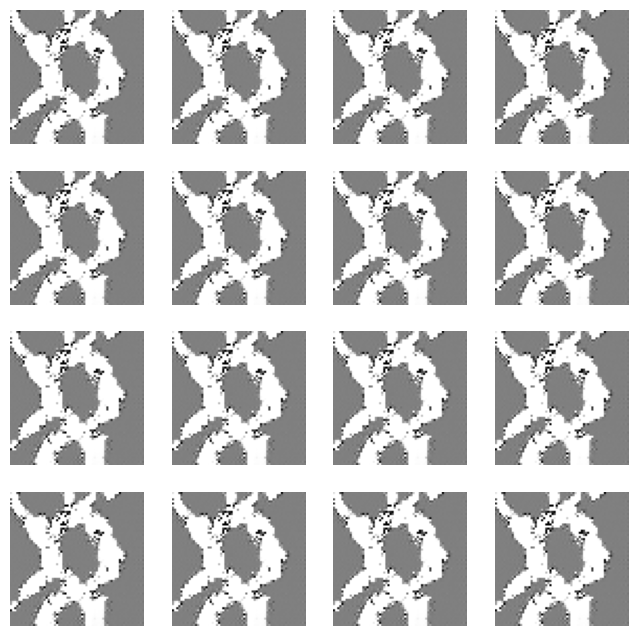

In [ ]:
# Gerar imagens após o treinamento
with torch.no_grad():
    z = torch.randn(16, latent_dim)  # Gerar 16 vetores aleatórios
    generated_images = generator(z)

# Visualizar as imagens geradas
plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(generated_images[i].squeeze().numpy(), cmap='gray')
    plt.axis('off')
plt.show()

In [ ]:
# Salvar os modelos treinados
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')